In [34]:
#Importing all the packages
import pandas_datareader as web
import quandl as quandl
import wrds as wrds
# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
# stats 
import statsmodels.api as sm
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn import linear_model
from statsmodels.regression.rolling import RollingOLS

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import table

# some useful path and file names
path         = Path('../zData')

# some file names 
fn_pred          = path / 'PredictorData2019.xlsx'
fn_h5_stocks     = path / 'stocks.h5'
fn_csv_factors   = path / 'ff_fact.csv'
fn_excel_factors = path / 'ff_fact.xls'
fn_h5_factors    = path / 'ff_predictors.h5'

fn_sent = path / 'AAIISentiment.csv'
fn_optd          = path / 'om_daily.h5'
fn_optm          = path / 'om_monthly.h5'

fn_sp500comp     = path / 'SP500_Index_Constitutes2019.csv'

fn_quandl_key = path / 'quandl-key.xlsx'
fn_link_all = path / 'daily_permno_secid_cusip_link.csv.zip'



In [3]:


# let us check the available datasets
sets = web.famafrench.get_available_datasets()


# from the datasets let us download the FF factors and put them into one DataFrame
startdt = datetime.datetime(1999,1,1)
d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt)
d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt)

k = d1[0]/100
k.reset_index(inplace=True)
p = pd.DataFrame(k)

q =d2[0]/100
q.reset_index(inplace=True)
q = pd.DataFrame(q)
q.rename(columns={'Date':'D','Mom':'MOM'},inplace =True)

ff = pd.concat([p,q],axis =1)

In [5]:
ff

,Date,Mkt-RF,SMB,HML,RF,D,Mom
0,1999-01-04,-0.0019,0.0015,0.0041,0.00019,1999-01-04,-0.0149
1,1999-01-05,0.0110,-0.0072,-0.0010,0.00019,1999-01-05,-0.0096
2,1999-01-06,0.0210,-0.0059,-0.0063,0.00019,1999-01-06,-0.0112
3,1999-01-07,-0.0007,0.0049,-0.0031,0.00019,1999-01-07,-0.0072
4,1999-01-08,0.0045,0.0007,0.0024,0.00019,1999-01-08,-0.0015
...,...,...,...,...,...,...,...
5531,2020-12-24,0.0022,-0.0039,-0.0017,0.00000,2020-12-24,0.0021
5532,2020-12-28,0.0046,-0.0072,0.0032,0.00000,2020-12-28,-0.0050
5533,2020-12-29,-0.0040,-0.0152,0.0024,0.00000,2020-12-29,-0.0044
5534,2020-12-30,0.0027,0.0099,0.0004,0.00000,2020-12-30,-0.0024


In [6]:
FF4 = ff.drop(columns='D')
FF4.columns = [z.strip() for z in FF4.columns]
FF4.rename(columns = {'Date':'date','Mkt-RF':'MKTRF', 'SMB':'SMB','HML':'HML','RF':'RF','Mom':'MOM'}, inplace = True)

In [7]:
# Fama French 4 factor
ff4f = FF4

In [9]:
ff4f

,date,MKTRF,SMB,HML,RF,MOM
0,1999-01-04,-0.0019,0.0015,0.0041,0.00019,-0.0149
1,1999-01-05,0.0110,-0.0072,-0.0010,0.00019,-0.0096
2,1999-01-06,0.0210,-0.0059,-0.0063,0.00019,-0.0112
3,1999-01-07,-0.0007,0.0049,-0.0031,0.00019,-0.0072
4,1999-01-08,0.0045,0.0007,0.0024,0.00019,-0.0015
...,...,...,...,...,...,...
5531,2020-12-24,0.0022,-0.0039,-0.0017,0.00000,0.0021
5532,2020-12-28,0.0046,-0.0072,0.0032,0.00000,-0.0050
5533,2020-12-29,-0.0040,-0.0152,0.0024,0.00000,-0.0044
5534,2020-12-30,0.0027,0.0099,0.0004,0.00000,-0.0024


# Getting S&P500

In [10]:
db = wrds.Connection(wrds_username='marizpan')
db.create_pgpass_file()



WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [11]:
comp = pd.read_csv(fn_sp500comp)
comp['start']  = pd.to_datetime(comp['start'])
comp['ending'] = pd.to_datetime(comp['ending'])
comp = comp.loc[comp.ending>'1998',:] 
comp.shape


(1111, 4)

In [12]:
# load the returns, shares outstanding and prices for SP500 companies (from 1999); 
# create a suitable dataframes/ compute market cap/ save
sql_wrds = """
select distinct date, permno, cusip, ret, abs(prc), shrout
from crsp.dsf 
where permno in %(permno)s and date>'1999-01-01'
"""
# specify the prm dictionary with permno

prm = {}
prm['permno'] = tuple(comp.permno.unique())

# get the data!
data_wrds = db.raw_sql(sql_wrds, params = prm)

data_wrds.to_hdf(path / 'wrds_data.h5', key = 'data', mode= 'a',data_columns = True, complib = 'zlib')

In [13]:
data_wrds.dtypes

date       object
permno    float64
cusip      object
ret       float64
abs       float64
shrout    float64
dtype: object

In [14]:
data_wrds = pd.read_hdf(path / 'wrds_data.h5', key = 'data')


In [16]:
data_wrds['date'] = pd.to_datetime(data_wrds['date'])

In [15]:
data_wrds.keys()

Index(['date', 'permno', 'cusip', 'ret', 'abs', 'shrout'], dtype='object')

In [17]:
data_wrds

,date,permno,cusip,ret,abs,shrout
0,1999-01-04,10078.0,86681020,0.051825,90.062500,385265.0
1,1999-01-04,10104.0,68389X10,-0.002899,43.000000,959712.0
2,1999-01-04,10107.0,59491810,0.016674,141.000000,2470000.0
3,1999-01-04,10108.0,86736310,-0.069291,36.937500,105369.0
4,1999-01-04,10137.0,01736110,-0.005435,34.312500,122436.0
...,...,...,...,...,...,...
4034161,2020-12-31,93089.0,92345Y10,0.008796,207.589996,162590.0
4034162,2020-12-31,93096.0,25667710,0.001763,210.300003,245001.0
4034163,2020-12-31,93132.0,34959E10,0.003445,148.529999,162332.0
4034164,2020-12-31,93422.0,74733V10,-0.016461,2.390000,242936.0


In [45]:
datab                = pd.merge(data_wrds.reset_index(),comp, how='left',on = ['permno','permno'])
datab['date']        = pd.to_datetime(datab['date'])


# data.loc[:,'sp500'] = 1*((data.date>data.start) & ((data.date<=data.ending) | 
#                                                    (data.ending==datetime.datetime(2020,12,31))))

# similar -- but slightly different choice

datab.loc[:,'sp500'] = (datab.loc[:,'date']>=datab.loc[:,'start']) & \
                        ((datab.loc[:,'date']<=datab.loc[:,'ending']) | (datab.loc[:,'date']> datab.ending.max()))


######
## think what happens if a stock exits the index and then enters it again! -- treat such a case! 
datab.sort_values(by = ['permno','date','sp500'], inplace = True)
datab = datab.groupby(['permno','date']).last().reset_index()

# create a link for each date
permno_cusip_link = datab.loc[:,['date','permno','cusip']].copy().set_index('date')
permno_cusip_link.to_hdf(fn_h5_stocks, key = 'stoxx/permno_cusip_link', mode= 'a',
                         data_columns = True, complib = 'zlib')

## create the market cap 
datab.sort_values(by = ['permno','date'], inplace = True)
datab.loc[:,'mktcap'] = abs(datab['abs'])*datab['shrout']/1e6
# shift the market cap by 1 day to compute value weights 
datab.loc[:,'mktcapL'] = datab.groupby(['permno'])['mktcap'].shift(1)*datab.loc[:,'sp500'].astype(int)
# compute the weights 
datab.loc[:,'sp500'] = datab.groupby(['date'])['mktcapL'].apply(lambda x: x/sum(x)).replace(0.0,np.nan)


datab.drop(columns   = {'index','Unnamed: 0', 'start', 'ending', 'mktcapL'}, inplace = True)
datab

,permno,date,cusip,ret,abs,shrout,sp500,mktcap
0,10078.0,1999-01-04,86681020,0.051825,90.062500,385265.0,NaN,34.697929
1,10078.0,1999-01-05,86681020,0.027759,92.562500,385265.0,0.003533,35.661092
2,10078.0,1999-01-06,86681020,-0.017556,90.937500,385265.0,0.003583,35.035036
3,10078.0,1999-01-07,86681020,-0.013746,89.687500,385265.0,0.003443,34.553455
4,10078.0,1999-01-08,86681020,0.013240,90.875000,385265.0,0.003401,35.010957
...,...,...,...,...,...,...,...,...
4034161,93429.0,2020-12-24,12503M10,0.010428,92.050003,108042.0,0.000306,9.945266
4034162,93429.0,2020-12-28,12503M10,0.013580,93.300003,108042.0,0.000308,10.080319
4034163,93429.0,2020-12-29,12503M10,-0.017578,91.660004,108042.0,0.000310,9.903130
4034164,93429.0,2020-12-30,12503M10,0.010473,92.620003,108042.0,0.000305,10.006850


In [58]:
datab.to_hdf(fn_h5_stocks, key = 'stoxx/panel', mode= 'a',
                       data_columns = True, complib = 'zlib')

In [47]:
data_ff = pd.merge(datab,ff4f, how='left',left_on = 'date',right_on = 'date')

In [48]:
data_ff

,permno,date,cusip,ret,abs,shrout,sp500,mktcap,MKTRF,SMB,HML,RF,MOM
0,10078.0,1999-01-04,86681020,0.051825,90.062500,385265.0,NaN,34.697929,-0.0019,0.0015,0.0041,0.00019,-0.0149
1,10078.0,1999-01-05,86681020,0.027759,92.562500,385265.0,0.003533,35.661092,0.0110,-0.0072,-0.0010,0.00019,-0.0096
2,10078.0,1999-01-06,86681020,-0.017556,90.937500,385265.0,0.003583,35.035036,0.0210,-0.0059,-0.0063,0.00019,-0.0112
3,10078.0,1999-01-07,86681020,-0.013746,89.687500,385265.0,0.003443,34.553455,-0.0007,0.0049,-0.0031,0.00019,-0.0072
4,10078.0,1999-01-08,86681020,0.013240,90.875000,385265.0,0.003401,35.010957,0.0045,0.0007,0.0024,0.00019,-0.0015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034161,93429.0,2020-12-24,12503M10,0.010428,92.050003,108042.0,0.000306,9.945266,0.0022,-0.0039,-0.0017,0.00000,0.0021
4034162,93429.0,2020-12-28,12503M10,0.013580,93.300003,108042.0,0.000308,10.080319,0.0046,-0.0072,0.0032,0.00000,-0.0050
4034163,93429.0,2020-12-29,12503M10,-0.017578,91.660004,108042.0,0.000310,9.903130,-0.0040,-0.0152,0.0024,0.00000,-0.0044
4034164,93429.0,2020-12-30,12503M10,0.010473,92.620003,108042.0,0.000305,10.006850,0.0027,0.0099,0.0004,0.00000,-0.0024


In [49]:
om_daily = pd.read_hdf(fn_optd )

In [50]:
om_daily

,date,secid,skew,iv
0,1999-01-04,5036.0,-0.003847,0.297523
1,1999-01-05,5036.0,-0.021454,0.299491
2,1999-01-12,5036.0,-0.024512,0.298423
3,1999-01-15,5036.0,-0.043310,0.292225
4,1999-01-21,5036.0,-0.042018,0.315739
...,...,...,...,...
159387,2019-12-12,213780.0,-0.238227,0.353408
159388,2019-12-17,213780.0,-0.442561,0.413738
159389,2019-12-20,213780.0,0.541843,0.363421
159390,2019-12-26,213780.0,-0.338157,0.821388


In [64]:
om_daily.dtypes

date     datetime64[ns]
secid           float64
skew            float64
iv              float64
dtype: object

In [53]:
from zipfile import ZipFile
zip_file = ZipFile(fn_link_all)

link_all = pd.read_csv(zip_file.open('daily_permno_secid_cusip_link.csv'))

In [54]:

link_all.loc[:,'date'] = pd.to_datetime(link_all.loc[:,'date'])

In [55]:
link_all

,permno,date,cusip,secid,ticker,issuer
0,10057.0,1995-01-03,00462610,5008.0,NaN,NaN
1,10057.0,1995-01-04,00462610,5008.0,NaN,NaN
2,10057.0,1995-01-05,00462610,5008.0,NaN,NaN
3,10057.0,1995-01-06,00462610,5008.0,NaN,NaN
4,10057.0,1995-01-09,00462610,5008.0,NaN,NaN
...,...,...,...,...,...,...
4908503,93429.0,2019-12-24,12503M10,143077.0,CBOE,CBOE GLOBAL MARKETS INC.
4908504,93429.0,2019-12-26,12503M10,143077.0,CBOE,CBOE GLOBAL MARKETS INC.
4908505,93429.0,2019-12-27,12503M10,143077.0,CBOE,CBOE GLOBAL MARKETS INC.
4908506,93429.0,2019-12-30,12503M10,143077.0,CBOE,CBOE GLOBAL MARKETS INC.


In [59]:
datain = pd.read_hdf(fn_h5_stocks, key = '/stoxx/panel')

In [60]:
data_all_ff = pd.merge(data_ff, link_all.loc[:,['permno', 'date', 'secid']], on = ['permno','date'])

In [61]:
data_all_ff

,permno,date,cusip,ret,abs,shrout,sp500,mktcap,MKTRF,SMB,HML,RF,MOM,secid
0,10078.0,1999-01-04,86681020,0.051825,90.062500,385265.0,NaN,34.697929,-0.0019,0.0015,0.0041,0.00019,-0.0149,110611.0
1,10078.0,1999-01-05,86681020,0.027759,92.562500,385265.0,0.003533,35.661092,0.0110,-0.0072,-0.0010,0.00019,-0.0096,110611.0
2,10078.0,1999-01-06,86681020,-0.017556,90.937500,385265.0,0.003583,35.035036,0.0210,-0.0059,-0.0063,0.00019,-0.0112,110611.0
3,10078.0,1999-01-07,86681020,-0.013746,89.687500,385265.0,0.003443,34.553455,-0.0007,0.0049,-0.0031,0.00019,-0.0072,110611.0
4,10078.0,1999-01-08,86681020,0.013240,90.875000,385265.0,0.003401,35.010957,0.0045,0.0007,0.0024,0.00019,-0.0015,110611.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878450,93429.0,2019-12-24,12503M10,0.005664,118.970001,110861.0,0.000472,13.189133,0.0001,0.0037,-0.0002,0.00007,0.0013,143077.0
3878451,93429.0,2019-12-26,12503M10,0.000672,119.050003,110861.0,0.000475,13.198002,0.0048,-0.0053,-0.0002,0.00007,0.0032,143077.0
3878452,93429.0,2019-12-27,12503M10,-0.001764,118.839996,110861.0,0.000473,13.174721,-0.0010,-0.0053,-0.0007,0.00007,0.0037,143077.0
3878453,93429.0,2019-12-30,12503M10,0.003450,119.250000,110861.0,0.000472,13.220174,-0.0057,0.0017,0.0059,0.00007,0.0004,143077.0


In [63]:
params = {}
# dataall_ff.secid
params['secids'] = tuple(data_all_ff.secid.unique())

In [89]:
data_all = pd.merge(data_all_ff, om_daily, how = 'inner', on = ['secid','date'])

In [90]:
data_all.head()

,permno,date,cusip,ret,abs,shrout,sp500,mktcap,MKTRF,SMB,HML,RF,MOM,secid,skew,iv
0,10078.0,1999-01-04,86681020,0.051825,90.0625,385265.0,NaN,34.697929,-0.0019,0.0015,0.0041,0.00019,-0.0149,110611.0,-0.047593,0.497590
1,10078.0,1999-01-05,86681020,0.027759,92.5625,385265.0,0.003533,35.661092,0.0110,-0.0072,-0.0010,0.00019,-0.0096,110611.0,-0.046228,0.491813
2,10078.0,1999-01-06,86681020,-0.017556,90.9375,385265.0,0.003583,35.035036,0.0210,-0.0059,-0.0063,0.00019,-0.0112,110611.0,-0.043389,0.509343
3,10078.0,1999-01-07,86681020,-0.013746,89.6875,385265.0,0.003443,34.553455,-0.0007,0.0049,-0.0031,0.00019,-0.0072,110611.0,-0.029926,0.519664
4,10078.0,1999-01-08,86681020,0.013240,90.8750,385265.0,0.003401,35.010957,0.0045,0.0007,0.0024,0.00019,-0.0015,110611.0,-0.036677,0.517651


In [91]:
data_all.keys()


Index(['permno', 'date', 'cusip', 'ret', 'abs', 'shrout', 'sp500', 'mktcap',
       'MKTRF', 'SMB', 'HML', 'RF', 'MOM', 'secid', 'skew', 'iv'],
      dtype='object')

In [106]:
def beta_cal(df):
    
    final = pd.DataFrame([])
    for x in df.permno.unique():
        
        print("calculating for permno: ", x)
        #creating datatable for each stock
        a = df[df['permno'] == x]

        if len(a) > 252:
            #running rolling regression for 1 year
            endog = a.ret - a.RF
            exog_vars = ['MKTRF', 'SMB', 'HML', 'MOM']
            exog = sm.add_constant(a[exog_vars])
            rols = RollingOLS(endog, exog, window=252)
            rres = rols.fit()

            #merging the parameters with the dataframe for that stock
            b = rres.params
            b.rename(columns = {'MKTRF':'BETA_MKTRF','SMB':'BETA_SMB','HML':'BETA_HML','MOM':'BETA_MOM'},
             inplace = True)
            b['date'] = a['date']
            c = a.merge(b)

            final = final.append(c)
            continue
        else:
            continue
        
    return final

In [107]:
final_beta = beta_cal(data_all)

calculating for permno:  10078.0
calculating for permno:  10104.0
calculating for permno:  10107.0
calculating for permno:  10108.0
calculating for permno:  10137.0
calculating for permno:  10138.0
calculating for permno:  10145.0
calculating for permno:  10147.0
calculating for permno:  10225.0
calculating for permno:  10299.0
calculating for permno:  10324.0
calculating for permno:  10364.0
calculating for permno:  10401.0
calculating for permno:  10516.0
calculating for permno:  10562.0
calculating for permno:  10604.0
calculating for permno:  10693.0
calculating for permno:  10696.0
calculating for permno:  10725.0
calculating for permno:  10786.0
calculating for permno:  10791.0
calculating for permno:  10874.0
calculating for permno:  10890.0
calculating for permno:  10909.0
calculating for permno:  10942.0
calculating for permno:  10989.0
calculating for permno:  11042.0
calculating for permno:  11081.0
calculating for permno:  11308.0
calculating for permno:  11340.0
calculatin

In [110]:
final_beta

,permno,date,cusip,ret,abs,shrout,sp500,mktcap,MKTRF,SMB,...,RF,MOM,secid,skew,iv,const,BETA_MKTRF,BETA_SMB,BETA_HML,BETA_MOM
0,10078.0,1999-01-04,86681020,0.051825,90.062500,385265.0,NaN,34.697929,-0.0019,0.0015,...,0.00019,-0.0149,110611.0,-0.047593,0.497590,NaN,NaN,NaN,NaN,NaN
1,10078.0,1999-01-05,86681020,0.027759,92.562500,385265.0,0.003533,35.661092,0.0110,-0.0072,...,0.00019,-0.0096,110611.0,-0.046228,0.491813,NaN,NaN,NaN,NaN,NaN
2,10078.0,1999-01-06,86681020,-0.017556,90.937500,385265.0,0.003583,35.035036,0.0210,-0.0059,...,0.00019,-0.0112,110611.0,-0.043389,0.509343,NaN,NaN,NaN,NaN,NaN
3,10078.0,1999-01-07,86681020,-0.013746,89.687500,385265.0,0.003443,34.553455,-0.0007,0.0049,...,0.00019,-0.0072,110611.0,-0.029926,0.519664,NaN,NaN,NaN,NaN,NaN
4,10078.0,1999-01-08,86681020,0.013240,90.875000,385265.0,0.003401,35.010957,0.0045,0.0007,...,0.00019,-0.0015,110611.0,-0.036677,0.517651,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,93429.0,2019-12-24,12503M10,0.005664,118.970001,110861.0,0.000472,13.189133,0.0001,0.0037,...,0.00007,0.0013,143077.0,-0.114522,0.201264,0.000493,0.447270,-0.476210,0.085167,0.394352
2394,93429.0,2019-12-26,12503M10,0.000672,119.050003,110861.0,0.000475,13.198002,0.0048,-0.0053,...,0.00007,0.0032,143077.0,-0.116238,0.205552,0.000471,0.412453,-0.464802,0.076934,0.381006
2395,93429.0,2019-12-27,12503M10,-0.001764,118.839996,110861.0,0.000473,13.174721,-0.0010,-0.0053,...,0.00007,0.0037,143077.0,-0.088774,0.205807,0.000424,0.407093,-0.447515,0.075821,0.380892
2396,93429.0,2019-12-30,12503M10,0.003450,119.250000,110861.0,0.000472,13.220174,-0.0057,0.0017,...,0.00007,0.0004,143077.0,-0.156374,0.218705,0.000409,0.405144,-0.462615,0.071690,0.373961


In [111]:
final_beta.to_hdf(path / 'Assignment_1.h5',key = 'assign1', 
               mode= 'a',data_columns = True, complib = 'zlib')

In [112]:
df1 = pd.read_hdf('Assignment_1.h5')

In [113]:
df1 = final_beta.set_index('date')

In [129]:
df1

,permno,ret,abs,shrout,sp500,mktcap,MKTRF,SMB,HML,RF,MOM,skew,iv,const,BETA_MKTRF,BETA_SMB,BETA_HML,BETA_MOM
date,,,,,,,,,,,,,,,,,,
1999-01-04,10078.0,0.051825,90.062500,385265.0,NaN,34.697929,-0.0019,0.0015,0.0041,0.00019,-0.0149,-0.047593,0.497590,NaN,NaN,NaN,NaN,NaN
1999-01-05,10078.0,0.027759,92.562500,385265.0,0.003533,35.661092,0.0110,-0.0072,-0.0010,0.00019,-0.0096,-0.046228,0.491813,NaN,NaN,NaN,NaN,NaN
1999-01-06,10078.0,-0.017556,90.937500,385265.0,0.003583,35.035036,0.0210,-0.0059,-0.0063,0.00019,-0.0112,-0.043389,0.509343,NaN,NaN,NaN,NaN,NaN
1999-01-07,10078.0,-0.013746,89.687500,385265.0,0.003443,34.553455,-0.0007,0.0049,-0.0031,0.00019,-0.0072,-0.029926,0.519664,NaN,NaN,NaN,NaN,NaN
1999-01-08,10078.0,0.013240,90.875000,385265.0,0.003401,35.010957,0.0045,0.0007,0.0024,0.00019,-0.0015,-0.036677,0.517651,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,93429.0,0.005664,118.970001,110861.0,0.000472,13.189133,0.0001,0.0037,-0.0002,0.00007,0.0013,-0.114522,0.201264,0.000493,0.447270,-0.476210,0.085167,0.394352
2019-12-26,93429.0,0.000672,119.050003,110861.0,0.000475,13.198002,0.0048,-0.0053,-0.0002,0.00007,0.0032,-0.116238,0.205552,0.000471,0.412453,-0.464802,0.076934,0.381006
2019-12-27,93429.0,-0.001764,118.839996,110861.0,0.000473,13.174721,-0.0010,-0.0053,-0.0007,0.00007,0.0037,-0.088774,0.205807,0.000424,0.407093,-0.447515,0.075821,0.380892


In [123]:
df1.keys()

Index(['permno', 'cusip', 'ret', 'abs', 'shrout', 'sp500', 'mktcap', 'MKTRF',
       'SMB', 'HML', 'RF', 'MOM', 'secid', 'skew', 'iv', 'const', 'BETA_MKTRF',
       'BETA_SMB', 'BETA_HML', 'BETA_MOM'],
      dtype='object')

In [133]:
df1.drop(columns=['const'],inplace=True)

In [134]:
df2= df1.copy()

In [135]:
df2

,permno,ret,abs,shrout,sp500,mktcap,MKTRF,SMB,HML,RF,MOM,skew,iv,BETA_MKTRF,BETA_SMB,BETA_HML,BETA_MOM
date,,,,,,,,,,,,,,,,,
1999-01-04,10078.0,0.051825,90.062500,385265.0,NaN,34.697929,-0.0019,0.0015,0.0041,0.00019,-0.0149,-0.047593,0.497590,NaN,NaN,NaN,NaN
1999-01-05,10078.0,0.027759,92.562500,385265.0,0.003533,35.661092,0.0110,-0.0072,-0.0010,0.00019,-0.0096,-0.046228,0.491813,NaN,NaN,NaN,NaN
1999-01-06,10078.0,-0.017556,90.937500,385265.0,0.003583,35.035036,0.0210,-0.0059,-0.0063,0.00019,-0.0112,-0.043389,0.509343,NaN,NaN,NaN,NaN
1999-01-07,10078.0,-0.013746,89.687500,385265.0,0.003443,34.553455,-0.0007,0.0049,-0.0031,0.00019,-0.0072,-0.029926,0.519664,NaN,NaN,NaN,NaN
1999-01-08,10078.0,0.013240,90.875000,385265.0,0.003401,35.010957,0.0045,0.0007,0.0024,0.00019,-0.0015,-0.036677,0.517651,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,93429.0,0.005664,118.970001,110861.0,0.000472,13.189133,0.0001,0.0037,-0.0002,0.00007,0.0013,-0.114522,0.201264,0.447270,-0.476210,0.085167,0.394352
2019-12-26,93429.0,0.000672,119.050003,110861.0,0.000475,13.198002,0.0048,-0.0053,-0.0002,0.00007,0.0032,-0.116238,0.205552,0.412453,-0.464802,0.076934,0.381006
2019-12-27,93429.0,-0.001764,118.839996,110861.0,0.000473,13.174721,-0.0010,-0.0053,-0.0007,0.00007,0.0037,-0.088774,0.205807,0.407093,-0.447515,0.075821,0.380892


In [138]:
df2.describe()

,permno,ret,abs,shrout,sp500,mktcap,MKTRF,SMB,HML,RF,MOM,skew,iv,BETA_MKTRF,BETA_SMB,BETA_HML,BETA_MOM
count,3.666253e+06,3.665917e+06,3.665983e+06,3.666253e+06,963999.000000,3.665983e+06,3.666253e+06,3.666253e+06,3.666253e+06,3.666253e+06,3.666253e+06,3.654758e+06,3.654758e+06,3.417992e+06,3.417992e+06,3.417992e+06,3.417992e+06
mean,5.650504e+04,6.035884e-04,5.422775e+01,4.645392e+05,0.002018,2.148068e+01,2.750087e-04,1.016798e-04,6.384963e-05,7.061283e-05,1.721667e-04,-1.107489e-01,3.759073e-01,1.045625e+00,1.752666e-01,1.205351e-01,-8.004625e-02
std,2.800677e+04,2.636244e-02,7.296226e+01,9.521309e+05,0.003749,4.608108e+01,1.202469e-02,6.098022e-03,6.649435e-03,7.513535e-05,9.789368e-03,1.083088e-01,1.891453e-01,3.595127e-01,4.968215e-01,7.149514e-01,5.743997e-01
min,1.007800e+04,-9.424658e-01,6.000000e-02,6.698000e+03,0.000005,6.863310e-03,-8.950000e-02,-4.710000e-02,-4.390000e-02,0.000000e+00,-8.190000e-02,-2.820493e+00,3.593806e-02,-2.772088e+00,-4.268437e+00,-5.715673e+00,-3.276392e+01
25%,2.638200e+04,-9.954067e-03,2.453000e+01,1.077130e+05,0.000464,3.690948e+00,-4.900000e-03,-3.400000e-03,-3.000000e-03,0.000000e+00,-4.100000e-03,-1.405620e-01,2.502040e-01,8.118056e-01,-1.434763e-01,-2.826822e-01,-3.302995e-01
50%,6.230800e+04,3.269117e-04,4.046000e+01,2.030950e+05,0.000844,8.357575e+00,6.000000e-04,2.000000e-04,-1.000000e-04,5.000000e-05,6.000000e-04,-8.610200e-02,3.275112e-01,1.020655e+00,9.286541e-02,7.073783e-02,-4.550452e-02
75%,8.229800e+04,1.076926e-02,6.337000e+01,4.252350e+05,0.001808,1.912431e+01,5.900000e-03,3.600000e-03,2.800000e-03,1.300000e-04,4.800000e-03,-5.330200e-02,4.437196e-01,1.248904e+00,3.994340e-01,4.973107e-01,2.043304e-01
max,9.342900e+04,1.283784e+00,3.540000e+03,2.920640e+07,0.051520,1.288147e+03,1.135000e-01,3.780000e-02,4.830000e-02,2.600000e-04,7.010000e-02,2.643680e+00,2.900105e+00,4.132393e+00,1.699336e+01,1.417159e+01,5.502328e+00


In [139]:
df3= df2.copy()
var_win = ['iv','skew','BETA_MKTRF','BETA_SMB', 'BETA_HML', 'BETA_MOM']
for z in var_win:
    goods    = df3[z].notna()
    df3.loc[goods,z] = winsorize(df3.loc[goods,z], limits=0.01).data

In [140]:
df3.describe()

,permno,ret,abs,shrout,sp500,mktcap,MKTRF,SMB,HML,RF,MOM,skew,iv,BETA_MKTRF,BETA_SMB,BETA_HML,BETA_MOM
count,3.666253e+06,3.665917e+06,3.665983e+06,3.666253e+06,963999.000000,3.665983e+06,3.666253e+06,3.666253e+06,3.666253e+06,3.666253e+06,3.666253e+06,3.654758e+06,3.654758e+06,3.417992e+06,3.417992e+06,3.417992e+06,3.417992e+06
mean,5.650504e+04,6.035884e-04,5.422775e+01,4.645392e+05,0.002018,2.148068e+01,2.750087e-04,1.016798e-04,6.384963e-05,7.061283e-05,1.721667e-04,-1.099406e-01,3.738966e-01,1.044873e+00,1.732635e-01,1.185953e-01,-8.033688e-02
std,2.800677e+04,2.636244e-02,7.296226e+01,9.521309e+05,0.003749,4.608108e+01,1.202469e-02,6.098022e-03,6.649435e-03,7.513535e-05,9.789368e-03,9.312694e-02,1.782068e-01,3.456404e-01,4.735030e-01,6.694675e-01,5.273880e-01
min,1.007800e+04,-9.424658e-01,6.000000e-02,6.698000e+03,0.000005,6.863310e-03,-8.950000e-02,-4.710000e-02,-4.390000e-02,0.000000e+00,-8.190000e-02,-5.059000e-01,1.477832e-01,2.744029e-01,-7.261436e-01,-1.687670e+00,-1.895955e+00
25%,2.638200e+04,-9.954067e-03,2.453000e+01,1.077130e+05,0.000464,3.690948e+00,-4.900000e-03,-3.400000e-03,-3.000000e-03,0.000000e+00,-4.100000e-03,-1.405620e-01,2.502040e-01,8.118056e-01,-1.434763e-01,-2.826822e-01,-3.302995e-01
50%,6.230800e+04,3.269117e-04,4.046000e+01,2.030950e+05,0.000844,8.357575e+00,6.000000e-04,2.000000e-04,-1.000000e-04,5.000000e-05,6.000000e-04,-8.610200e-02,3.275112e-01,1.020655e+00,9.286541e-02,7.073783e-02,-4.550452e-02
75%,8.229800e+04,1.076926e-02,6.337000e+01,4.252350e+05,0.001808,1.912431e+01,5.900000e-03,3.600000e-03,2.800000e-03,1.300000e-04,4.800000e-03,-5.330200e-02,4.437196e-01,1.248904e+00,3.994340e-01,4.973107e-01,2.043304e-01
max,9.342900e+04,1.283784e+00,3.540000e+03,2.920640e+07,0.051520,1.288147e+03,1.135000e-01,3.780000e-02,4.830000e-02,2.600000e-04,7.010000e-02,5.064300e-02,1.071590e+00,2.075763e+00,1.810570e+00,2.146448e+00,1.581752e+00


In [141]:
df4 = df3.copy()
for z in var_win:
    df4['val_%s'%z] =df4['sp500']*df4[z]

In [142]:
df4

,permno,ret,abs,shrout,sp500,mktcap,MKTRF,SMB,HML,RF,...,BETA_MKTRF,BETA_SMB,BETA_HML,BETA_MOM,val_iv,val_skew,val_BETA_MKTRF,val_BETA_SMB,val_BETA_HML,val_BETA_MOM
date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,10078.0,0.051825,90.062500,385265.0,NaN,34.697929,-0.0019,0.0015,0.0041,0.00019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-05,10078.0,0.027759,92.562500,385265.0,0.003533,35.661092,0.0110,-0.0072,-0.0010,0.00019,...,NaN,NaN,NaN,NaN,0.001737,-0.000163,NaN,NaN,NaN,NaN
1999-01-06,10078.0,-0.017556,90.937500,385265.0,0.003583,35.035036,0.0210,-0.0059,-0.0063,0.00019,...,NaN,NaN,NaN,NaN,0.001825,-0.000155,NaN,NaN,NaN,NaN
1999-01-07,10078.0,-0.013746,89.687500,385265.0,0.003443,34.553455,-0.0007,0.0049,-0.0031,0.00019,...,NaN,NaN,NaN,NaN,0.001789,-0.000103,NaN,NaN,NaN,NaN
1999-01-08,10078.0,0.013240,90.875000,385265.0,0.003401,35.010957,0.0045,0.0007,0.0024,0.00019,...,NaN,NaN,NaN,NaN,0.001760,-0.000125,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,93429.0,0.005664,118.970001,110861.0,0.000472,13.189133,0.0001,0.0037,-0.0002,0.00007,...,0.447270,-0.476210,0.085167,0.394352,0.000095,-0.000054,0.000211,-0.000225,0.000040,0.000186
2019-12-26,93429.0,0.000672,119.050003,110861.0,0.000475,13.198002,0.0048,-0.0053,-0.0002,0.00007,...,0.412453,-0.464802,0.076934,0.381006,0.000098,-0.000055,0.000196,-0.000221,0.000037,0.000181
2019-12-27,93429.0,-0.001764,118.839996,110861.0,0.000473,13.174721,-0.0010,-0.0053,-0.0007,0.00007,...,0.407093,-0.447515,0.075821,0.380892,0.000097,-0.000042,0.000192,-0.000211,0.000036,0.000180


In [156]:
df4.isnull().sum(axis = 0)

permno                  0
ret                   336
abs                   270
shrout                  0
sp500             2702254
mktcap                270
MKTRF                   0
SMB                     0
HML                     0
RF                      0
MOM                     0
skew                11495
iv                  11495
BETA_MKTRF         248261
BETA_SMB           248261
BETA_HML           248261
BETA_MOM           248261
val_iv            2703168
val_skew          2703168
val_BETA_MKTRF    2815729
val_BETA_SMB      2815729
val_BETA_HML      2815729
val_BETA_MOM      2815729
dtype: int64

In [157]:
iv_graph = df4.groupby(['date'])['val_iv'].mean()
skew_graph = df4.groupby(['date'])['val_skew'].sum()
mktrf_graph = df4.groupby(['date'])['val_BETA_MKTRF'].sum(min_count=1)
smb_gaph = df4.groupby(['date'])['val_BETA_SMB'].sum(min_count=1)
hml_graph = df4.groupby(['date'])['val_BETA_HML'].sum(min_count=1)
mom_graph = df4.groupby(['date'])['val_BETA_MOM'].sum(min_count=1)

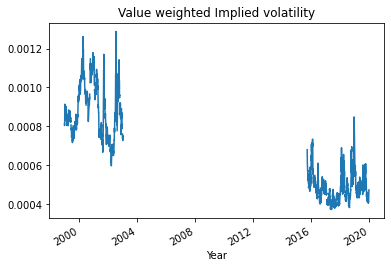

In [158]:
iv_graph.plot()
plt.title('Value weighted Implied volatility')
plt.xlabel("Year")
plt.savefig(path / 'IV.png');

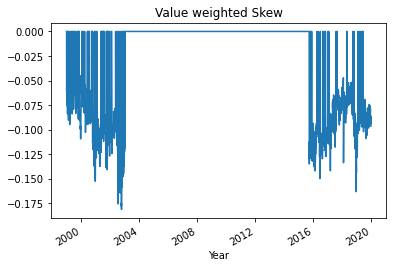

In [149]:
skew_graph.plot()
plt.title('Value weighted Skew')
plt.xlabel("Year")
plt.savefig(path / 'skew.png');

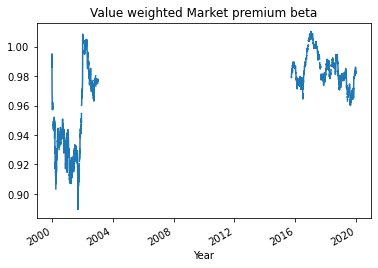

In [150]:
mktrf_graph.plot()
plt.title('Value weighted Market premium beta')
plt.xlabel("Year")
plt.savefig(path / 'mktrf.png');

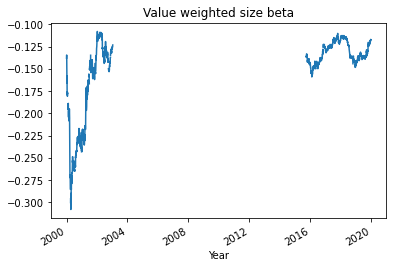

In [152]:
smb_gaph.plot()
plt.title('Value weighted size beta')
plt.xlabel("Year")
plt.savefig(path / 'smb.png');

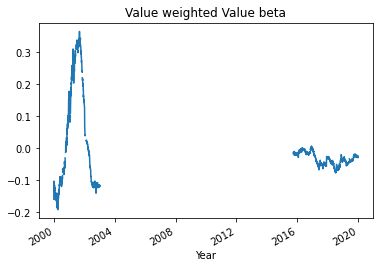

In [153]:
hml_graph.plot()
plt.title('Value weighted Value beta')
plt.xlabel("Year")
plt.savefig(path / 'hml.png');

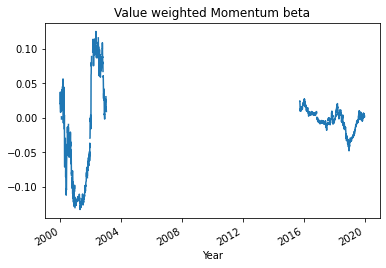

In [154]:
mom_graph.plot()
plt.title('Value weighted Momentum beta')
plt.xlabel("Year")
plt.savefig(path / 'mom.png');